In [23]:
#Load packages
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Features and target
X = final_xT_results[['home_xT', 'away_xT']]
y = final_xT_results['goal_difference'].astype(int)  # ensure target is integer

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Starting parameter optimization...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters found:
max_depth: 10
min_samples_leaf: 4
min_samples_split: 10
n_estimators: 200
Best MSE: 4.1336


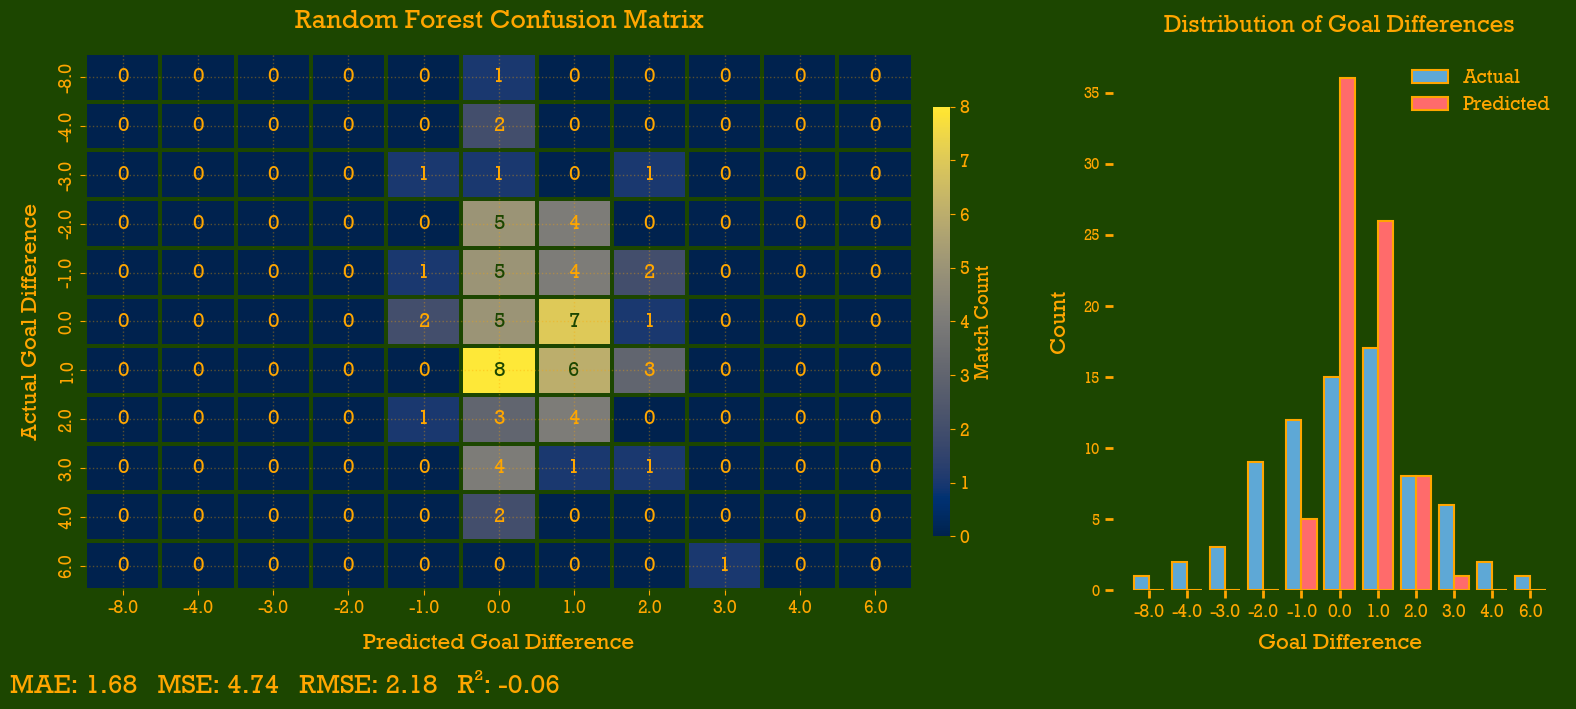

In [27]:
# Define parameter grid for optimization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize base model
rf_base = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit grid search
print('Starting parameter optimization...')
grid_search.fit(X_train, y_train)

# Print best parameters and score
print('\nBest parameters found:')
for param, value in grid_search.best_params_.items():
    print(f'{param}: {value}')
print(f'Best MSE: {-grid_search.best_score_:.4f}')

# Use best model for predictions
rf_model = grid_search.best_estimator_

# Make predictions and round them
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_rounded = np.round(y_pred_rf)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred_rf_rounded)
mse = mean_squared_error(y_test, y_pred_rf_rounded)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf_rounded)

# Use only unique values present in the data for axes and bar labels
gd_range = np.sort(np.unique(np.concatenate([y_test, y_pred_rf_rounded])))

# Compute confusion matrix with only present labels
cm = confusion_matrix(y_test, y_pred_rf_rounded, labels=gd_range)

# Prepare counts for bar chart (using only present values)
pred_counts = pd.Series(y_pred_rf_rounded).value_counts().reindex(gd_range, fill_value=0)
actual_counts = pd.Series(y_test).value_counts().reindex(gd_range, fill_value=0)

# Create subplots: Confusion matrix (left), bar chart (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [2.2, 1]}, facecolor='#1c4600')
plt.rcParams['font.family'] = 'Rockwell'

# Add metrics at the top
fig.text(0.01, 0.01,
    f"MAE: {mae:.2f}   MSE: {mse:.2f}   RMSE: {rmse:.2f}   R²: {r2:.2f}",
    fontsize=18, fontweight='bold', color='#ffa600', fontname='Rockwell', va='top', ha='left')

# Add extra space at the top for metrics
plt.subplots_adjust(top=0.68)

# Subtle speckle background for confusion matrix
speckle = np.random.binomial(1, 0.07, (128, 128))
extent = [0, len(gd_range), 0, len(gd_range)]
ax1.imshow(speckle, extent=extent, aspect='auto', cmap='mako', alpha=0.07, zorder=0)

# Confusion matrix heatmap
cmap = plt.get_cmap('cividis')
norm = plt.Normalize(vmin=cm.min(), vmax=cm.max())
hm = sns.heatmap(
    cm,
    annot=False,  # We'll add custom annotations for dynamic color
    fmt='d',
    cmap=cmap,
    xticklabels=gd_range,
    yticklabels=gd_range,
    linewidths=1.5,
    linecolor='#1c4600',
    cbar=True,
    cbar_kws={'shrink': 0.8, 'aspect': 25, 'pad': 0.02, 'label': 'Match Count'},
    ax=ax1
)
# Style the colorbar (legend)
cbar = hm.collections[0].colorbar
cbar.set_label('Match Count', color='#ffa600', fontsize=13, fontname='Rockwell')
cbar.ax.yaxis.label.set_color('#ffa600')
cbar.ax.yaxis.label.set_fontname('Rockwell')
cbar.ax.tick_params(colors='#ffa600', labelsize=12)
for label in cbar.ax.get_yticklabels():
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')

ax1.set_facecolor('#1c4600')
ax1.set_xlabel('Predicted Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=12, fontname='Rockwell')
ax1.set_ylabel('Actual Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=12, fontname='Rockwell')
ax1.set_title('Random Forest Confusion Matrix', fontsize=18, fontweight='bold', color='#ffa600', pad=18, fontname='Rockwell')
ax1.tick_params(axis='both', labelsize=12, labelcolor='#ffa600', color='#ffa600', grid_color='#ffa600')
ax1.grid(axis='both', linestyle=':', linewidth=1, alpha=0.35, color='#ffa600')
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')
for spine in ax1.spines.values():
    spine.set_visible(False)

# Dynamic annotation color based on cell brightness
from matplotlib.colors import rgb_to_hsv, to_rgb
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        cell_color = cmap(norm(cm[i, j]))
        # Convert RGBA to HSV to check brightness
        rgb = to_rgb(cell_color[:3])
        hsv = rgb_to_hsv(rgb)
        text_color = '#1c4600' if hsv[2] > 0.6 else '#ffa600'
        ax1.text(j + 0.5, i + 0.5, f'{value}',
                 ha='center', va='center', fontsize=14, fontweight='bold', fontname='Rockwell', color=text_color)

# Bar chart of predicted vs actual counts
bar_width = 0.4
x = np.arange(len(gd_range))
ax2.bar(x - bar_width/2, actual_counts.values, width=bar_width, color='#5ea8d6', label='Actual', edgecolor='#ffa600', linewidth=1.5)
ax2.bar(x + bar_width/2, pred_counts.values, width=bar_width, color='#ff6b6b', label='Predicted', edgecolor='#ffa600', linewidth=1.5)
ax2.set_xticks(x)
ax2.set_xticklabels(gd_range, fontsize=12, fontweight='bold', color='#ffa600', fontname='Rockwell')
ax2.set_xlabel('Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=10, fontname='Rockwell')
ax2.set_ylabel('Count', fontsize=15, fontweight='bold', color='#ffa600', labelpad=10, fontname='Rockwell')
ax2.set_title('Distribution of Goal Differences', fontsize=16, fontweight='bold', color='#ffa600', pad=15, fontname='Rockwell')
ax2.legend(frameon=False, fontsize=13, labelcolor='#ffa600')
ax2.grid(False)  # Remove all grid lines from the bar chart
ax2.set_facecolor('#1c4600')
ax2.tick_params(axis='both', color='#ffa600', length=6, width=2)  # Make axis dashes #ffa600
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=2)
plt.show()

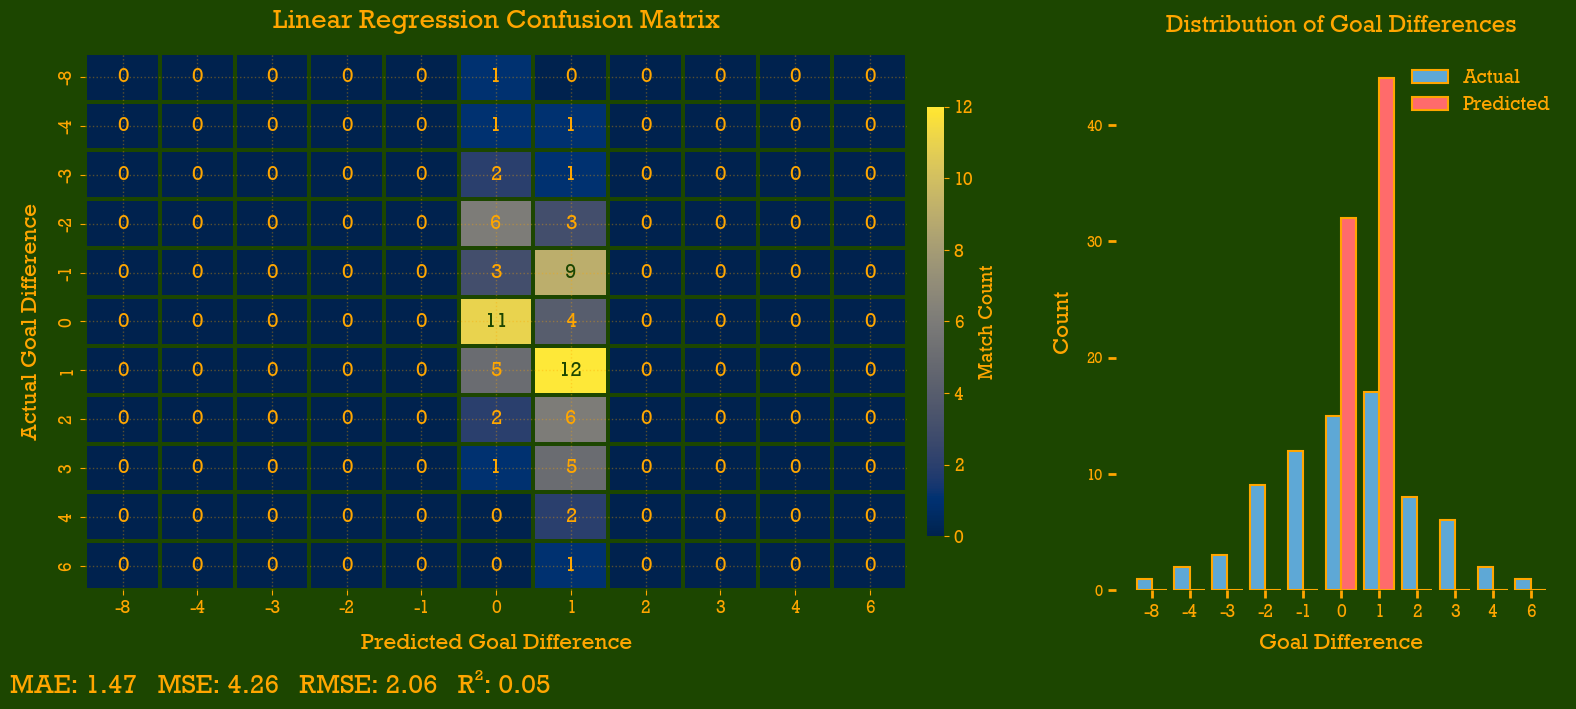

In [29]:
# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = np.round(lr.predict(X_test)).astype(int)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)

gd_range = np.sort(np.unique(np.concatenate([y_test, y_pred_lr])))
cm = confusion_matrix(y_test, y_pred_lr, labels=gd_range)
pred_counts = pd.Series(y_pred_lr).value_counts().reindex(gd_range, fill_value=0)
actual_counts = pd.Series(y_test).value_counts().reindex(gd_range, fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [2.2, 1]}, facecolor='#1c4600')
plt.rcParams['font.family'] = 'Rockwell'
fig.text(0.01, 0.01,
    f"MAE: {mae:.2f}   MSE: {mse:.2f}   RMSE: {rmse:.2f}   R²: {r2:.2f}",
    fontsize=18, fontweight='bold', color='#ffa600', fontname='Rockwell', va='top', ha='left')
plt.subplots_adjust(top=0.68)
speckle = np.random.binomial(1, 0.07, (128, 128))
extent = [0, len(gd_range), 0, len(gd_range)]
ax1.imshow(speckle, extent=extent, aspect='auto', cmap='mako', alpha=0.07, zorder=0)
cmap = plt.get_cmap('cividis')
norm = plt.Normalize(vmin=cm.min(), vmax=cm.max())
hm = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap=cmap,
    xticklabels=gd_range,
    yticklabels=gd_range,
    linewidths=1.5,
    linecolor='#1c4600',
    cbar=True,
    cbar_kws={'shrink': 0.8, 'aspect': 25, 'pad': 0.02, 'label': 'Match Count'},
    ax=ax1
)
cbar = hm.collections[0].colorbar
cbar.set_label('Match Count', color='#ffa600', fontsize=13, fontname='Rockwell')
cbar.ax.yaxis.label.set_color('#ffa600')
cbar.ax.yaxis.label.set_fontname('Rockwell')
cbar.ax.tick_params(colors='#ffa600', labelsize=12)
for label in cbar.ax.get_yticklabels():
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')
ax1.set_facecolor('#1c4600')
ax1.set_xlabel('Predicted Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=12, fontname='Rockwell')
ax1.set_ylabel('Actual Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=12, fontname='Rockwell')
ax1.set_title('Linear Regression Confusion Matrix', fontsize=18, fontweight='bold', color='#ffa600', pad=18, fontname='Rockwell')
ax1.tick_params(axis='both', labelsize=12, labelcolor='#ffa600', color='#ffa600', grid_color='#ffa600')
ax1.grid(axis='both', linestyle=':', linewidth=1, alpha=0.35, color='#ffa600')
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')
for spine in ax1.spines.values():
    spine.set_visible(False)
from matplotlib.colors import rgb_to_hsv, to_rgb
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        cell_color = cmap(norm(cm[i, j]))
        rgb = to_rgb(cell_color[:3])
        hsv = rgb_to_hsv(rgb)
        text_color = '#1c4600' if hsv[2] > 0.6 else '#ffa600'
        ax1.text(j + 0.5, i + 0.5, f'{value}',
                 ha='center', va='center', fontsize=14, fontweight='bold', fontname='Rockwell', color=text_color)
bar_width = 0.4
x = np.arange(len(gd_range))
ax2.bar(x - bar_width/2, actual_counts.values, width=bar_width, color='#5ea8d6', label='Actual', edgecolor='#ffa600', linewidth=1.5)
ax2.bar(x + bar_width/2, pred_counts.values, width=bar_width, color='#ff6b6b', label='Predicted', edgecolor='#ffa600', linewidth=1.5)
ax2.set_xticks(x)
ax2.set_xticklabels(gd_range, fontsize=12, fontweight='bold', color='#ffa600', fontname='Rockwell')
ax2.set_xlabel('Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=10, fontname='Rockwell')
ax2.set_ylabel('Count', fontsize=15, fontweight='bold', color='#ffa600', labelpad=10, fontname='Rockwell')
ax2.set_title('Distribution of Goal Differences', fontsize=16, fontweight='bold', color='#ffa600', pad=15, fontname='Rockwell')
ax2.legend(frameon=False, fontsize=13, labelcolor='#ffa600')
ax2.grid(False)
ax2.set_facecolor('#1c4600')
ax2.tick_params(axis='both', color='#ffa600', length=6, width=2)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')
for spine in ax2.spines.values():
    spine.set_visible(False)
plt.tight_layout(pad=2)
plt.show()


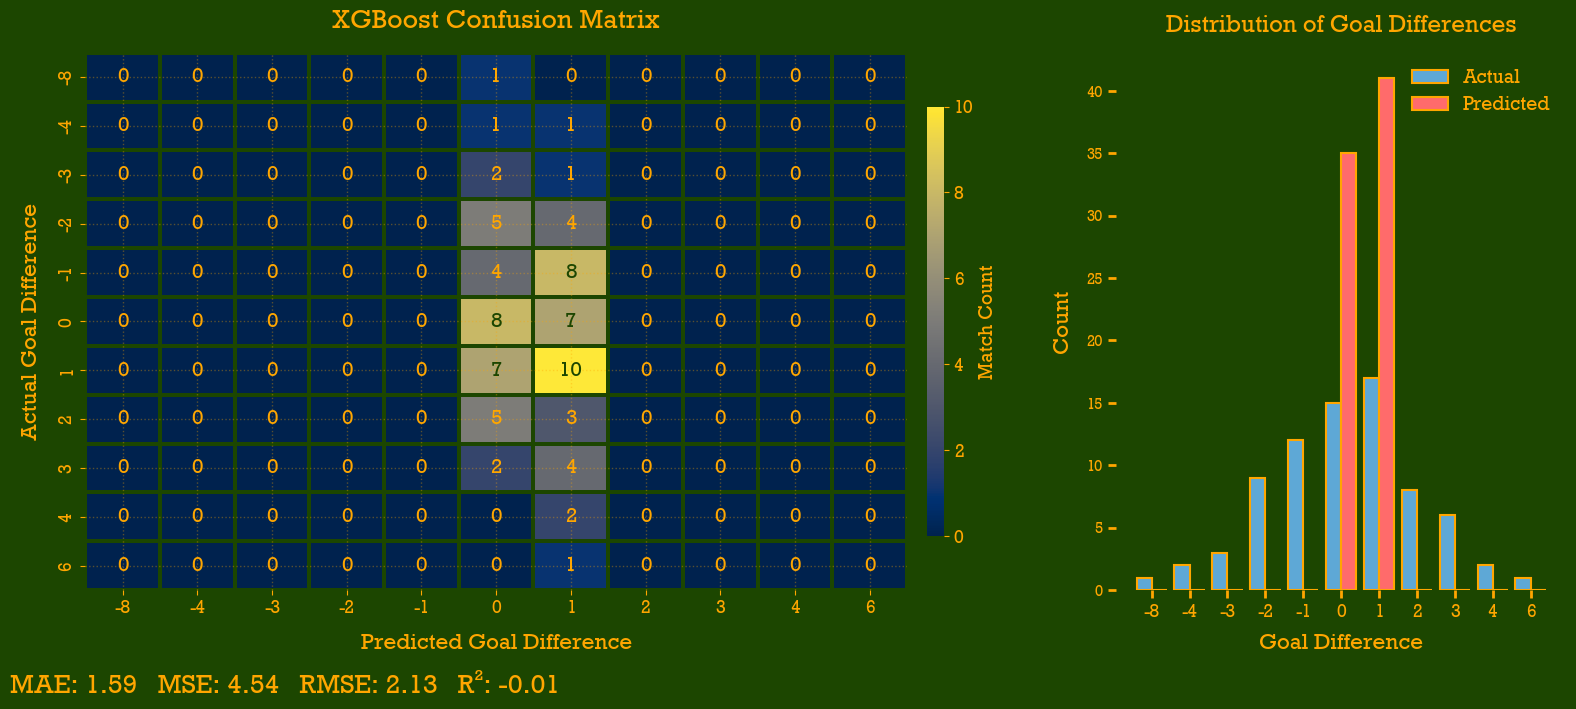

In [33]:
# --- Grid Search for Best XGBoost Hyperparameters ---

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}
# Run grid search and use best parameters for XGBoost automatically
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

# Fit XGBoost with best parameters from grid search
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)
y_pred_xgb = np.round(xgb_best.predict(X_test)).astype(int)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

gd_range = np.sort(np.unique(np.concatenate([y_test, y_pred_xgb])))
cm = confusion_matrix(y_test, y_pred_xgb, labels=gd_range)
pred_counts = pd.Series(y_pred_xgb).value_counts().reindex(gd_range, fill_value=0)
actual_counts = pd.Series(y_test).value_counts().reindex(gd_range, fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [2.2, 1]}, facecolor='#1c4600')
plt.rcParams['font.family'] = 'Rockwell'
fig.text(0.01, 0.01,
    f"MAE: {mae:.2f}   MSE: {mse:.2f}   RMSE: {rmse:.2f}   R²: {r2:.2f}",
    fontsize=18, fontweight='bold', color='#ffa600', fontname='Rockwell', va='top', ha='left')
plt.subplots_adjust(top=0.68)
speckle = np.random.binomial(1, 0.07, (128, 128))
extent = [0, len(gd_range), 0, len(gd_range)]
ax1.imshow(speckle, extent=extent, aspect='auto', cmap='mako', alpha=0.07, zorder=0)
cmap = plt.get_cmap('cividis')
norm = plt.Normalize(vmin=cm.min(), vmax=cm.max())
hm = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap=cmap,
    xticklabels=gd_range,
    yticklabels=gd_range,
    linewidths=1.5,
    linecolor='#1c4600',
    cbar=True,
    cbar_kws={'shrink': 0.8, 'aspect': 25, 'pad': 0.02, 'label': 'Match Count'},
    ax=ax1
)
cbar = hm.collections[0].colorbar
cbar.set_label('Match Count', color='#ffa600', fontsize=13, fontname='Rockwell')
cbar.ax.yaxis.label.set_color('#ffa600')
cbar.ax.yaxis.label.set_fontname('Rockwell')
cbar.ax.tick_params(colors='#ffa600', labelsize=12)
for label in cbar.ax.get_yticklabels():
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')
ax1.set_facecolor('#1c4600')
ax1.set_xlabel('Predicted Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=12, fontname='Rockwell')
ax1.set_ylabel('Actual Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=12, fontname='Rockwell')
ax1.set_title('XGBoost Confusion Matrix', fontsize=18, fontweight='bold', color='#ffa600', pad=18, fontname='Rockwell')
ax1.tick_params(axis='both', labelsize=12, labelcolor='#ffa600', color='#ffa600', grid_color='#ffa600')
ax1.grid(axis='both', linestyle=':', linewidth=1, alpha=0.35, color='#ffa600')
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')
for spine in ax1.spines.values():
    spine.set_visible(False)
from matplotlib.colors import rgb_to_hsv, to_rgb
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        cell_color = cmap(norm(cm[i, j]))
        rgb = to_rgb(cell_color[:3])
        hsv = rgb_to_hsv(rgb)
        text_color = '#1c4600' if hsv[2] > 0.6 else '#ffa600'
        ax1.text(j + 0.5, i + 0.5, f'{value}',
                 ha='center', va='center', fontsize=14, fontweight='bold', fontname='Rockwell', color=text_color)
bar_width = 0.4
x = np.arange(len(gd_range))
ax2.bar(x - bar_width/2, actual_counts.values, width=bar_width, color='#5ea8d6', label='Actual', edgecolor='#ffa600', linewidth=1.5)
ax2.bar(x + bar_width/2, pred_counts.values, width=bar_width, color='#ff6b6b', label='Predicted', edgecolor='#ffa600', linewidth=1.5)
ax2.set_xticks(x)
ax2.set_xticklabels(gd_range, fontsize=12, fontweight='bold', color='#ffa600', fontname='Rockwell')
ax2.set_xlabel('Goal Difference', fontsize=15, fontweight='bold', color='#ffa600', labelpad=10, fontname='Rockwell')
ax2.set_ylabel('Count', fontsize=15, fontweight='bold', color='#ffa600', labelpad=10, fontname='Rockwell')
ax2.set_title('Distribution of Goal Differences', fontsize=16, fontweight='bold', color='#ffa600', pad=15, fontname='Rockwell')
ax2.legend(frameon=False, fontsize=13, labelcolor='#ffa600')
ax2.grid(False)
ax2.set_facecolor('#1c4600')
ax2.tick_params(axis='both', color='#ffa600', length=6, width=2)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_color('#ffa600')
    label.set_fontname('Rockwell')
for spine in ax2.spines.values():
    spine.set_visible(False)
plt.tight_layout(pad=2)
plt.show()